# [WUM] PD5 - Mateusz Polakowski

Drzewa decyzyjne stanowią sporą część (oraz powszechnie używaną) metod z uczenia maszynowego. W tym raporcie przyjrzymy się wpływowi wartości hiperparametrów klasy *DecisionTreeClassifier* ze znanego pakietu *scikitlearn*. Cały proces oparty będzie na części ramki danych *Titanic* załadowanej przy użyciu pakietu *seaborn*.

Hiperparametry, których znaczenie zostało poruszone w artykule oraz którym będziemy się przyglądać to:
* *max_depth* - maksymalna wysokość drzewa,
* *min_samples_split* - minimalna liczba rekordów w zbiorze do podzielenia,
* *min_samples_leaf* - minimalna liczba rekordów w liściu drzewa decyzyjnego.

Ponieważ artykuł nie porusza *explicite* wpływu miary oceny jakości klasyfikatora (parametr *criterion*), to w tej pracy domowej zdamy się na domyślną wartość, czyli *critetion* = *gini*.

Zanim jednak przejdziemy do optymalizacji hiperparametrów, to stworzymy drzewa z domyślnymi wartościami (zmiana tylko w parametrze *criterion* dla dalszych wizualizacji), aby mieć z czym porównywać kolejne modele.

---

## Załadowanie potrzebnych pakietów i definicje funkcji

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from IPython.display import Image, display
from category_encoders import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']= (16, 9)

def evaluate_model(model, model_name, X, y):
    """
        Ewaulacja przekazanego modelu
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return pd.DataFrame({
        "Accuracy": np.round(accuracy_score(y_test, y_pred), 4),
        "Precision": np.round(precision_score(y_test, y_pred), 4),
        "Recall": np.round(recall_score(y_test, y_pred), 4)
    }, index=[model_name])

def visualize_DTree(tree_model, model_name, X, y):
    """
        Przy użyciu aplikacji graphviz wizualizuje model drzewa decyzyjnego
    """
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.15, random_state=1234)
    tree_model.fit(X_train, y_train)

    export_graphviz(tree_model, 
                    out_file=f'Visualizations/{model_name}.dot',
                    feature_names=X_train.columns)
    !dot -Tpng Visualizations/{model_name}.dot -o Visualizations/{model_name}.png 
    img = Image(filename=f'Visualizations/{model_name}.png')
    display(img)

## Wczytanie danych i podstawowe modele

In [3]:
df = sns.load_dataset("titanic").iloc[:, [0, 1, 2, 4, 5, 6, 7, 10]]
df = OneHotEncoder(cols=['sex', 'embarked']).fit_transform(df).drop(['sex_-1', 'embarked_-1'], axis=1)
X, y = df.drop("survived", axis=1), df.survived
df.head()

,sex_1,sex_2,embarked_1,embarked_2,embarked_3,embarked_4,survived,pclass,sibsp,parch,fare,adult_male
0,1,0,1,0,0,0,0,3,1,0,7.2500,True
1,0,1,0,1,0,0,1,1,1,0,71.2833,False
2,0,1,1,0,0,0,1,3,0,0,7.9250,False
3,0,1,1,0,0,0,1,1,1,0,53.1000,False
4,1,0,1,0,0,0,0,3,0,0,8.0500,True


In [4]:
scoring_df = evaluate_model(DecisionTreeClassifier(), "Default (gini) DTree", X, y)
scoring_df = scoring_df.append(evaluate_model(DecisionTreeClassifier('entropy'), "Default (entropy) DTree", X, y))
scoring_df

,Accuracy,Precision,Recall
Default (gini) DTree,0.8209,0.8298,0.7091
Default (entropy) DTree,0.8284,0.8333,0.7273


Domyślne hiperparametry, których użyto:
* *max_depth* - *None*
* *min_samples_split* - *2*
* *min_samples_leaf* - *1*

Rozszerzmy teraz tę tabelę o kolejne modele, o których jest mowa w pracy domowej.

## Model zaproponowany w artykule

W dołączonym artykule wartości hiperparametrów były następujące:
* *max_depth* - 21,
* *min_samples_split* - 24,
* *min_samples_leaf* - 12.

In [5]:
scoring_df = scoring_df.append(evaluate_model(DecisionTreeClassifier(max_depth=21,
                                                                     min_samples_split=24,
                                                                     min_samples_leaf=12), "Article DTree", 
                                              X, y))

scoring_df

,Accuracy,Precision,Recall
Default (gini) DTree,0.8209,0.8298,0.7091
Default (entropy) DTree,0.8284,0.8333,0.7273
Article DTree,0.8358,0.8837,0.6909


## Model stworzony przy użyciu RandomSearch

Poniżej zdamy się na algorytm losowego poszukiwania najlepszych hiperparametrów. Z około 27000 możliwych kombinacji iterujmy *RandomSearch* 7000 razy.

In [6]:
param_dist = {
    "max_depth": np.arange(1, 31),
    "min_samples_split": np.arange(2, 31), # tutaj mały wyjątek ze względu na znaczenie parametru w modelu
    "min_samples_leaf": np.arange(1, 31)
}

randCV_tree = RandomizedSearchCV(DecisionTreeClassifier(), 
                                 param_distributions=param_dist, 
                                 cv=10, 
                                 n_iter=7000,
                                )

X_train, _, y_train, _ = train_test_split(X, y, test_size=0.15, random_state=1234)
randCV_tree.fit(X_train, y_train)
best_randCV_tree = randCV_tree.best_estimator_

scoring_df = scoring_df.append(evaluate_model(best_randCV_tree, "RandomSearch DTree", X, y))
scoring_df

,Accuracy,Precision,Recall
Default (gini) DTree,0.8209,0.8298,0.7091
Default (entropy) DTree,0.8284,0.8333,0.7273
Article DTree,0.8358,0.8837,0.6909
RandomSearch DTree,0.7985,0.8043,0.6727


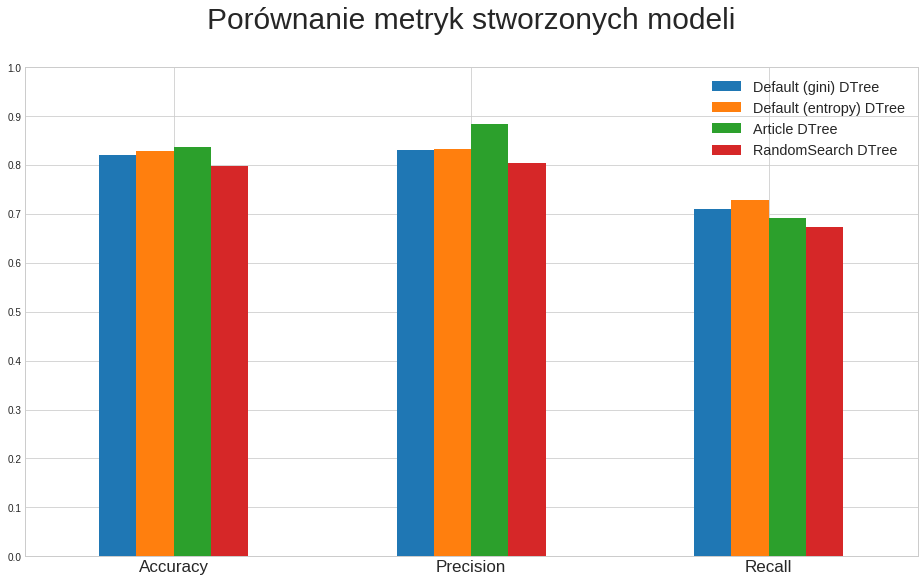

In [7]:
scoring_df.T.plot(kind="bar")
plt.xticks(size=17, rotation=0)
plt.yticks(np.linspace(0,1, 11))
plt.title("Porównanie metryk stworzonych modeli\n", size=30)
plt.legend(fontsize='x-large')
plt.show()

## Rysowanie drzew decyzyjnych

Przy użyciu *Graphviz* (program do wizualizacji drzew decyzyjnych) oraz funkcjonalności modułu *sklearn.tree* narysujmy potrzebne drzewa decyzyjne. Najpierw zwizualizujmy najlepsze drzewo decyzyjne, czyli te otrzymane przy użyciu wartości parametrów z artykułu:

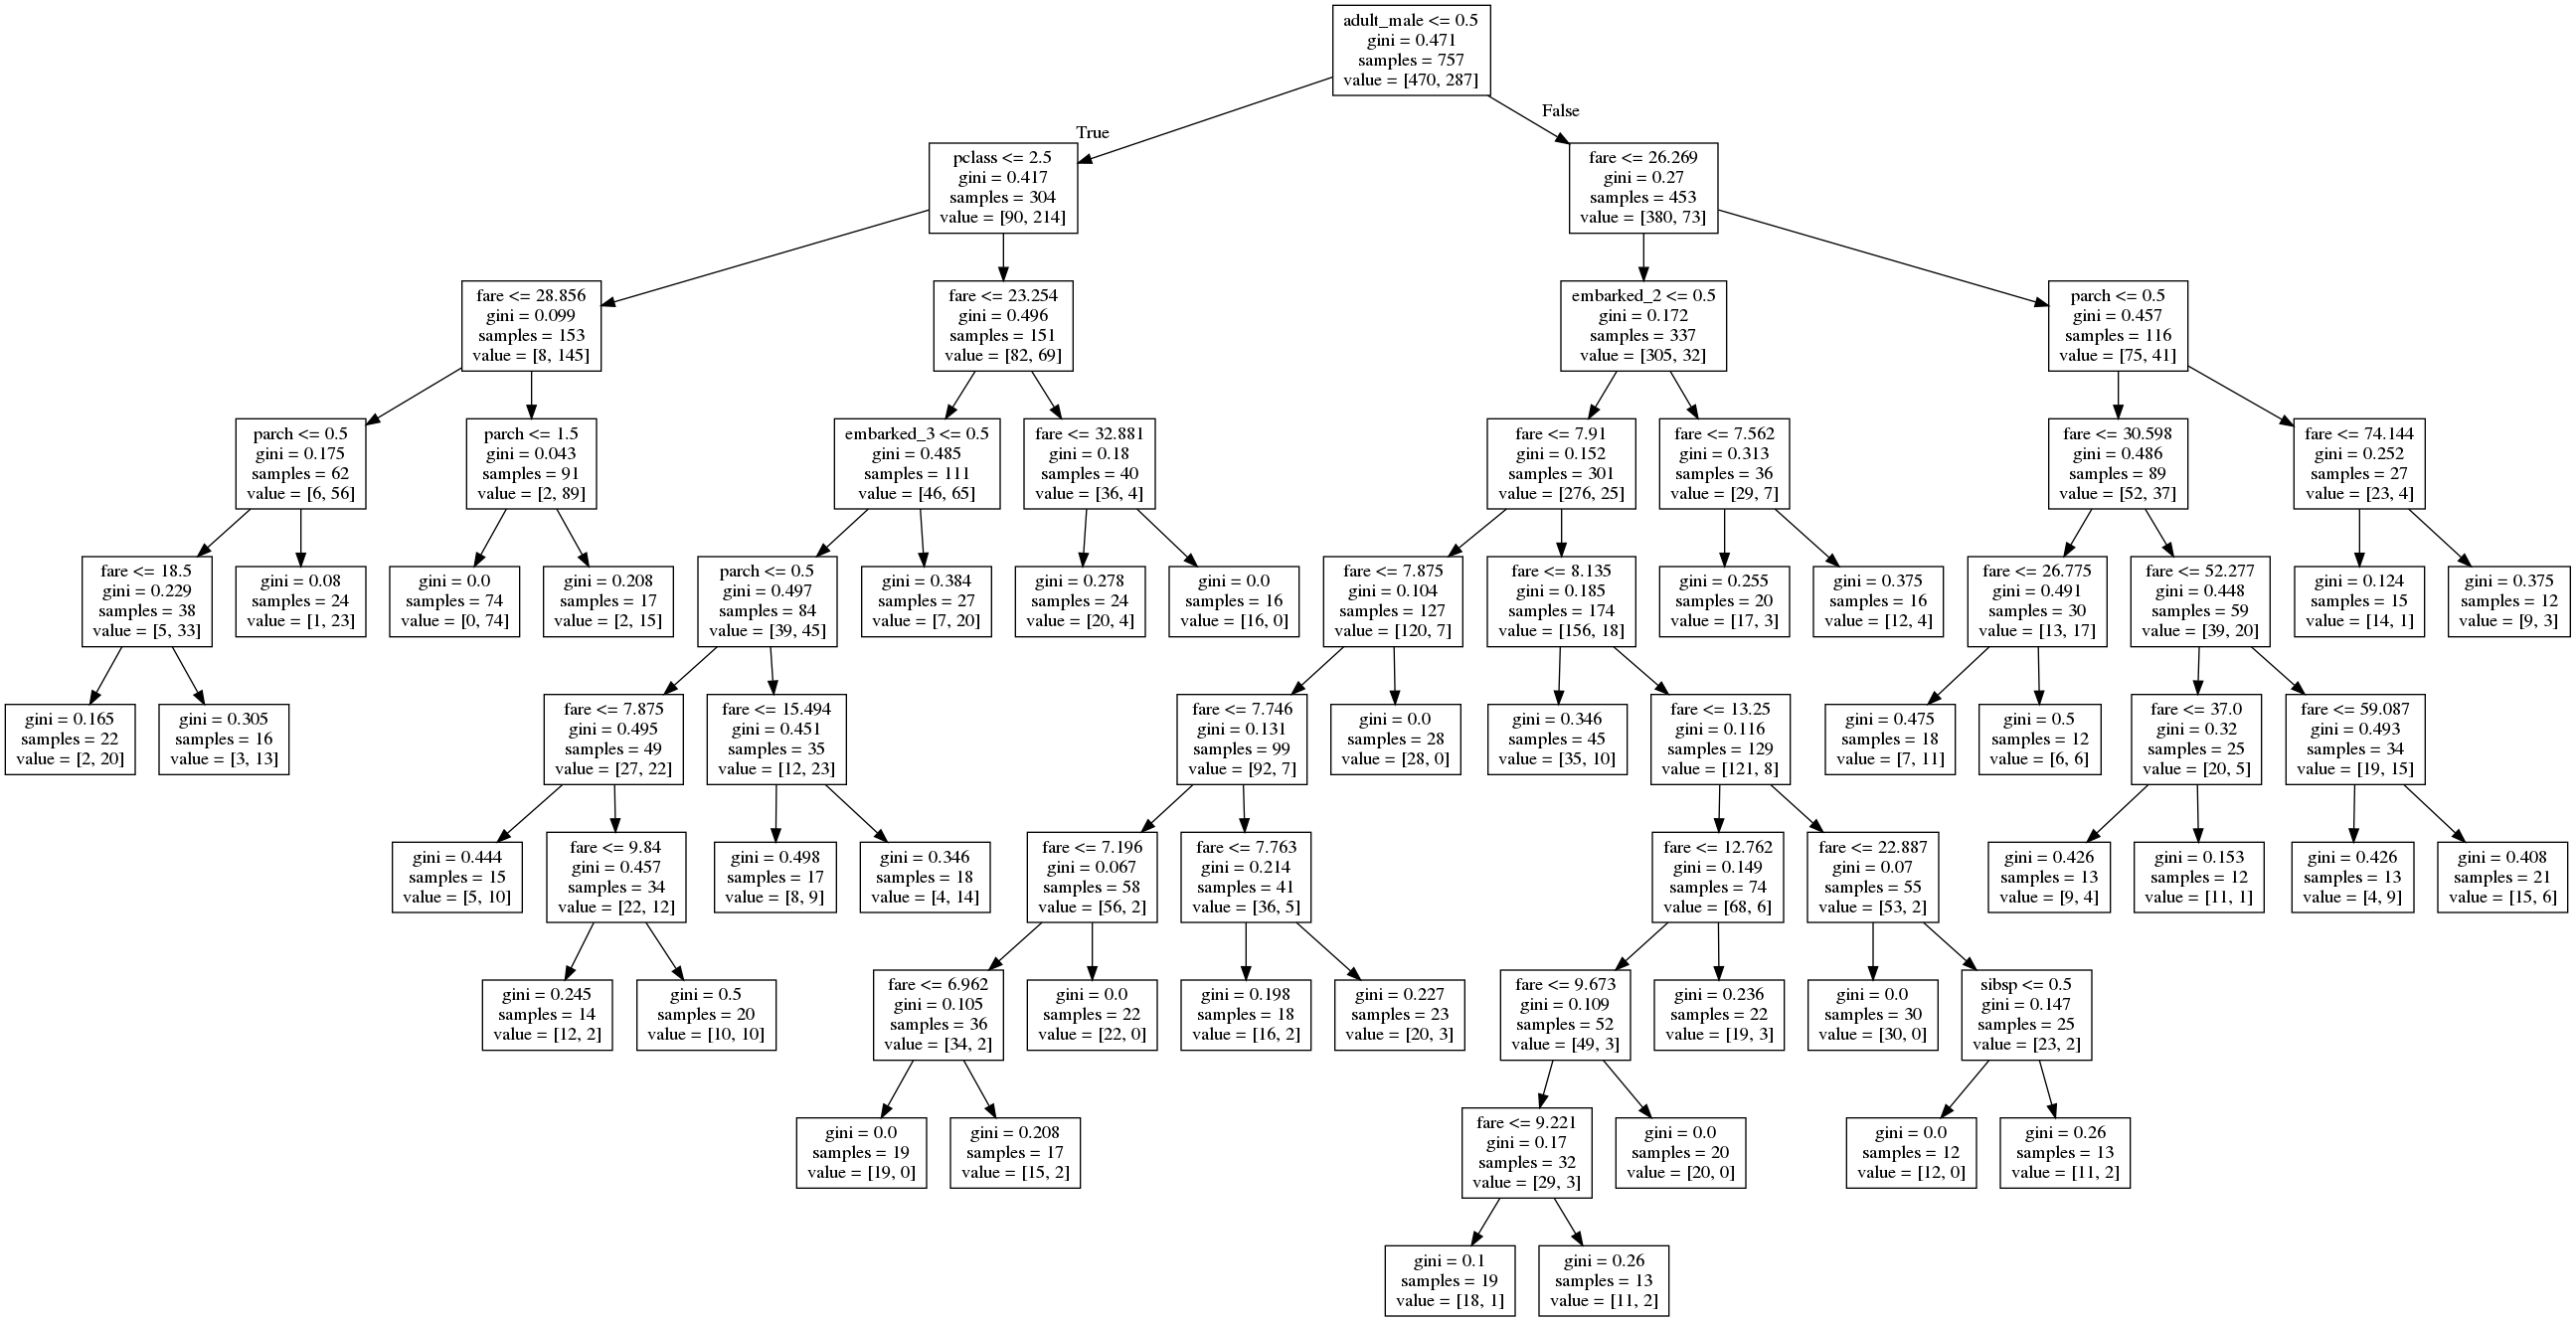

In [8]:
visualize_DTree(DecisionTreeClassifier(max_depth=21, min_samples_split=24, min_samples_leaf=12), 
                "best_tree", 
                X, y)

Poniżej porównajmy jeszcze drzewa uzyskane przy użyciu domyślnym hiperparametrów, lecz ze zmienioną funkcją miary jakości:

* *criterion* = *gini*

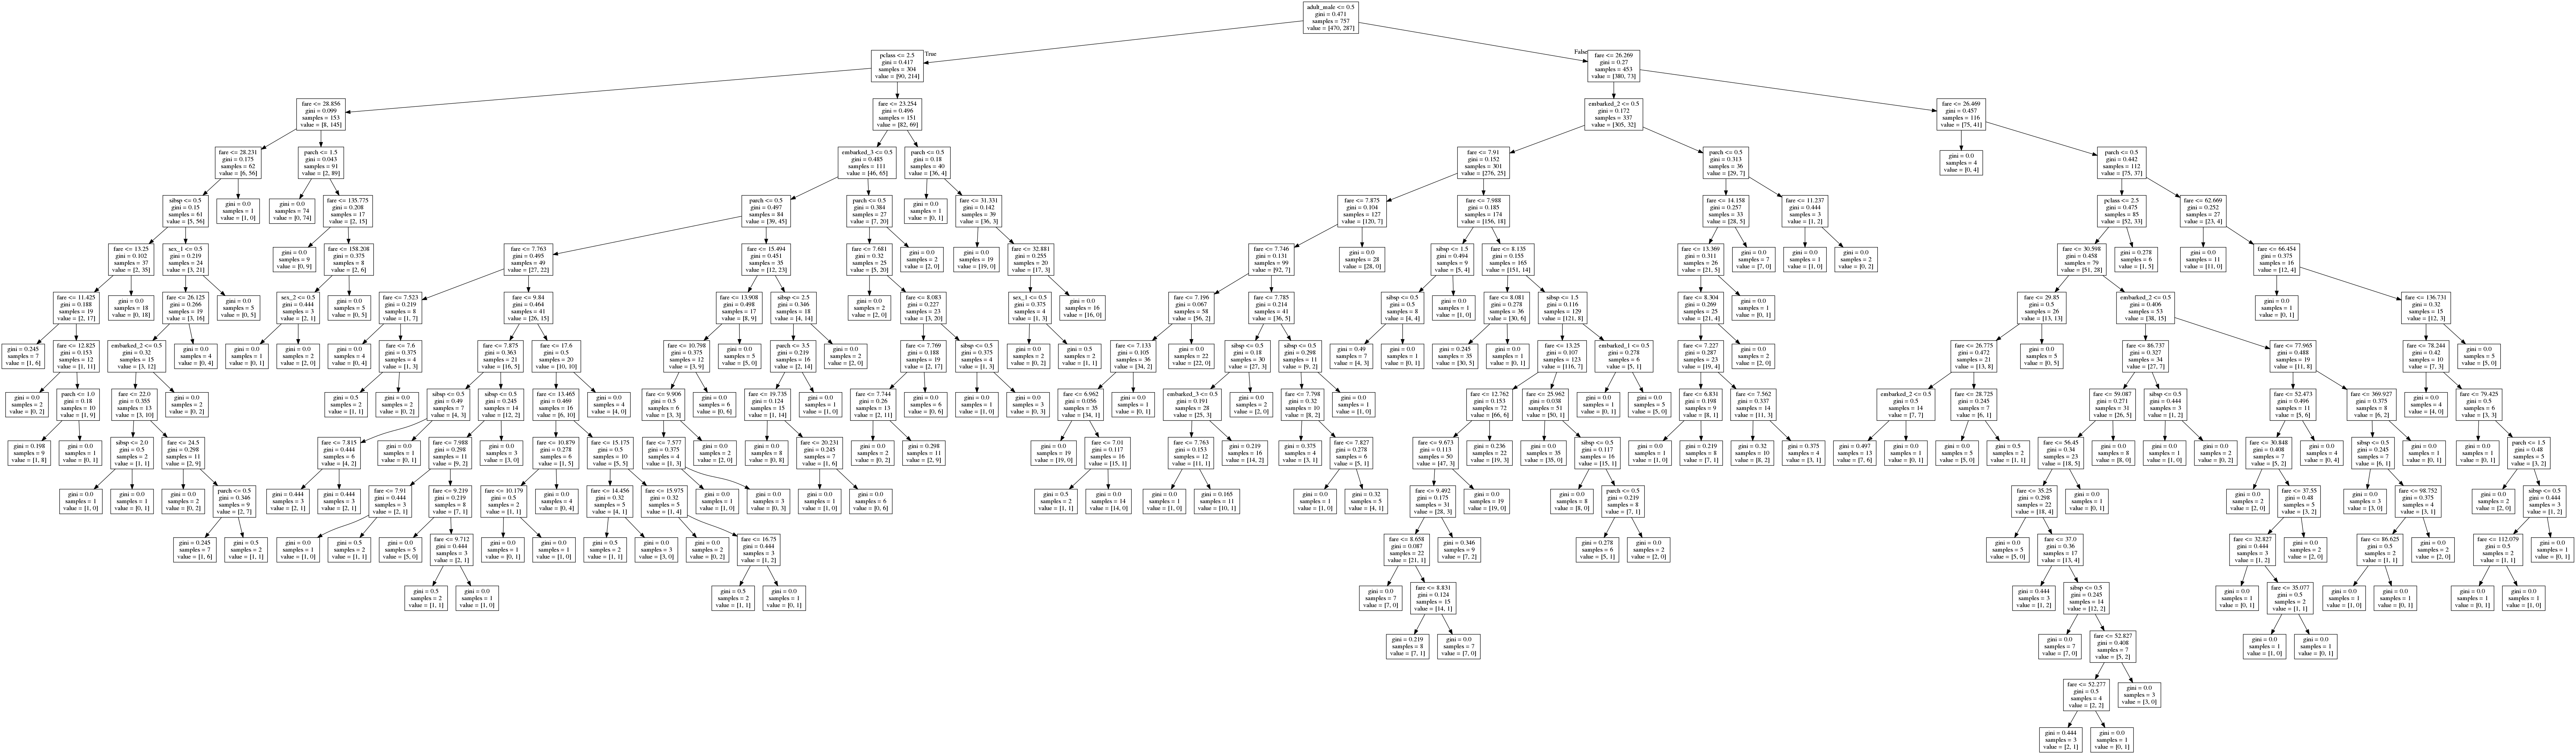

In [9]:
visualize_DTree(DecisionTreeClassifier(), "default_tree_gini", X, y)

* *criterion* = *entropy*

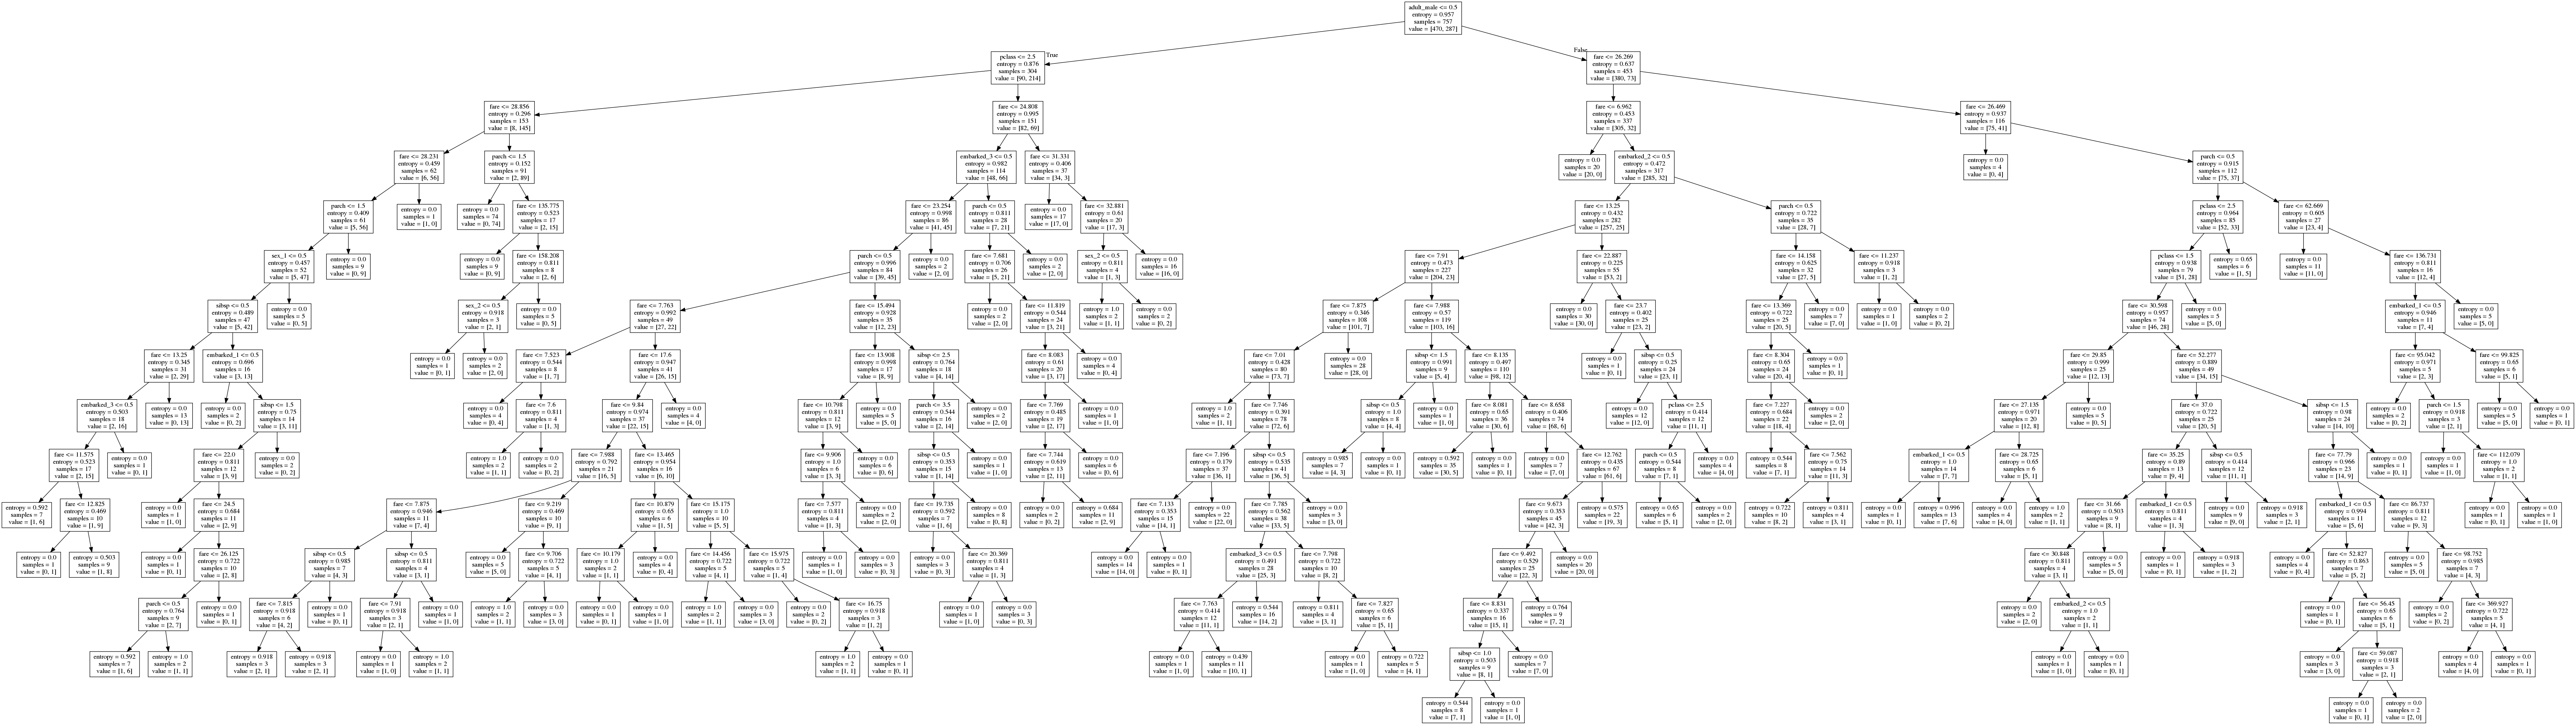

In [10]:
visualize_DTree(DecisionTreeClassifier(criterion='entropy'), "default_tree_entropy", X, y)

Jak widać, modele z domyślnymi wartościami pozwalają sobie na o wiele więcej - mimo, że wyniki metryk jakości na tym zbiorze są podobne do pozostałych drzew (oraz między sobą), to ich głębokość jest większa, co implikuje spore ryzyko przeuczenia się modelu. 

Poza drzewami domyślnymi nie powinno nas dziwić, że model z wartościami hiperparametrów zaczerpniętych z artykułu osiąga najlepsze wyniki. Bez tego raczej części artykułu by nie było. Warto mimo wszystko zwrócić uwagę, że zwiększając minimalne liczności próbek zmniejszamy skomplikowanie modelu, co rośnie proporcjonalnie wraz ze wzrostem parametru wysokości drzewa. Algorytm wtedy dzieli na więcej podgrup swoje dane.